In [31]:
# Importing the libraries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import yfinance as yf

In [32]:
# Importing the  dataset
ticker = '005930.KS'
ticker = yf.Ticker(ticker)
df =  ticker.history(period='10y')[['Open', 'High', 'Low', 'Close', 'Volume']]
df = df.reset_index()

df.head() #6 columns, including the Date. 

,Date,Open,High,Low,Close,Volume
0,2012-07-06,19355.865401,19355.865401,18691.216757,18820.904297,21158900
1,2012-07-09,18399.419969,18448.052797,18253.521484,18253.521484,21282300
2,2012-07-10,18399.417996,18512.894583,18172.464823,18269.730469,17720700
3,2012-07-11,18302.154355,18366.998125,17961.724557,18123.833984,18001300
4,2012-07-12,18172.460938,18253.515625,17686.132812,17686.132812,24858600


In [33]:
df1=df.reset_index()['Close']

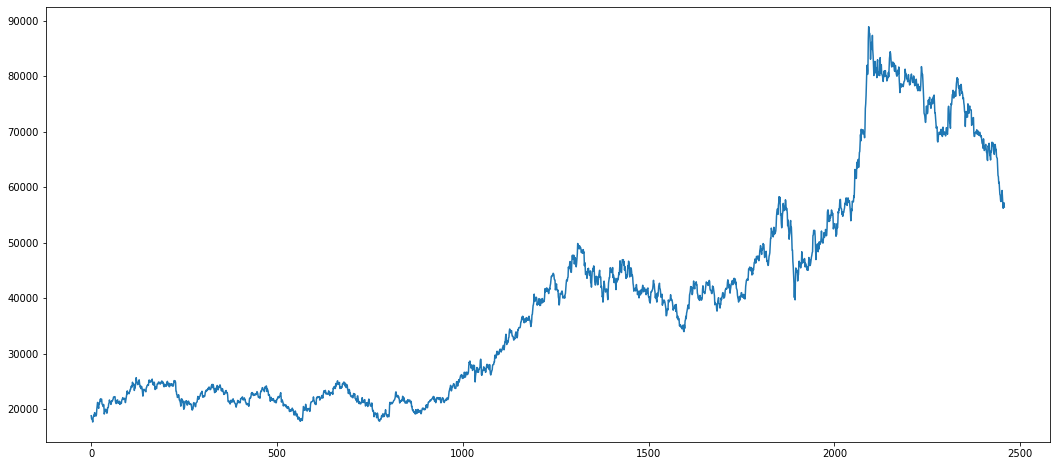

In [34]:
plt.figure(figsize=(18, 8))

plt.plot(df1)

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [36]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [37]:
training_size,test_size

(1597, 861)

In [39]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [40]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [41]:
print(X_train.shape), print(y_train.shape)

(1496, 100)
(1496,)


(None, None)

In [42]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [43]:
### Create the Stacked LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [44]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
24/24 [==============================] - 12s 268ms/step - loss: 0.0065 - val_loss: 0.0026
Epoch 2/100
24/24 [==============================] - 4s 164ms/step - loss: 6.1043e-04 - val_loss: 0.0092
Epoch 3/100
24/24 [==============================] - 4s 175ms/step - loss: 3.8258e-04 - val_loss: 0.0062
Epoch 4/100
24/24 [==============================] - 4s 166ms/step - loss: 3.7157e-04 - val_loss: 0.0056
Epoch 5/100
24/24 [==============================] - 4s 154ms/step - loss: 3.3992e-04 - val_loss: 0.0064
Epoch 6/100
24/24 [==============================] - 4s 162ms/step - loss: 3.2908e-04 - val_loss: 0.0059
Epoch 7/100
24/24 [==============================] - 4s 172ms/step - loss: 3.1748e-04 - val_loss: 0.0065
Epoch 8/100
24/24 [==============================] - 4s 166ms/step - loss: 3.0288e-04 - val_loss: 0.0052
Epoch 9/100
24/24 [==============================] - 6s 271ms/step - loss: 2.9642e-04 - val_loss: 0.0059
Epoch 10/100
24/24 [==============================] - 7s 2

In [46]:
model.save('C:/Users/dell/OneDrive/Desktop/Streamlit/LSTM_SAMSUNG.h5')

In [16]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [17]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [18]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [19]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

42.80399313570501

In [20]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

134.7851139529831

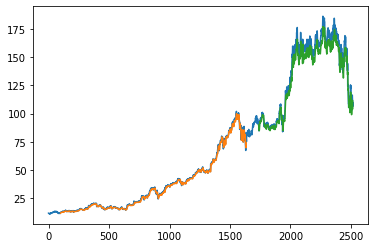

In [21]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [22]:
len(test_data)

881

In [23]:
x_input=test_data[(len(test_data)-100):].reshape(1,-1)
x_input.shape

(1, 100)

In [24]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.8569019310914667,
 0.8556277795373669,
 0.8431933449363147,
 0.8107137636652185,
 0.8213706353352106,
 0.8290126804226646,
 0.8380568997850836,
 0.8184439925387057,
 0.806777520672713,
 0.7931030449781032,
 0.7625545671080403,
 0.7997042436461592,
 0.8135293955735972,
 0.812246738103128,
 0.7984755727061158,
 0.8036547210293236,
 0.7800258929207765,
 0.7671848234402312,
 0.7206098104093083,
 0.7124272924521416,
 0.7309964890419766,
 0.7738769833364,
 0.7665221431190082,
 0.7456378617606104,
 0.7769997829797894,
 0.8096358557530683,
 0.8331565372106339,
 0.8559747862072097,
 0.8573456274637119,
 0.8766713298400273,
 0.8682470876268547,
 0.8696207931205017,
 0.876014291198029,
 0.9000014093348678,
 0.9018472799820777,
 0.8847029979742358,
 0.8659120399933433,
 0.8691116532692517,
 0.8963382236168309,
 0.8719272851776303,
 0.8417855289821253,
 0.8362594607841398,
 0.8173518502358965,
 0.7983617843759098,
 0.7964591497561944,
 0.8234979823781933,
 0.8016865561355383,
 0.8078213181243209

In [25]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
future_days = 300
while(i<future_days):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

Streaming output truncated to the last 5000 lines.
 0.76964781 0.73163356 0.72467121 0.76124344 0.64568766 0.64693052
 0.64552839 0.6550561  0.60089589 0.59159854 0.5575632  0.55796137
 0.53812661 0.54699165 0.58182906 0.56906189 0.59498871 0.54802694
 0.54920153 0.55074874 0.55055532 0.5308912  0.54610716 0.57058063
 0.59372593 0.62252531 0.63091254 0.6526813  0.63470088 0.6485801
 0.63839822 0.62804569 0.59943405 0.56246074 0.52844528 0.52070932
 0.55119808 0.52838843 0.54295021 0.55694318 0.55847897 0.57833083
 0.60119738 0.58276762 0.54966229 0.55830833 0.54289331 0.56194878
 0.51951057 0.51412666 0.50418538 0.49375671 0.48472166 0.47744179
 0.47164804 0.46687934 0.4626461  0.45849928 0.45407218 0.44911009
 0.4434835  0.43718353 0.43030295 0.42300653 0.41549623 0.40797719
 0.4006308  0.39359477 0.38695574 0.380748  ]
22 day output [[0.37496173]]
23 day input [0.74563786 0.77699978 0.80963586 0.83315654 0.85597479 0.85734563
 0.87667133 0.86824709 0.86962079 0.87601429 0.90000141 0.

In [26]:
day_new=np.arange(1,101)
day_pred=np.arange(101,101+future_days)

In [27]:
len(df1)

2517

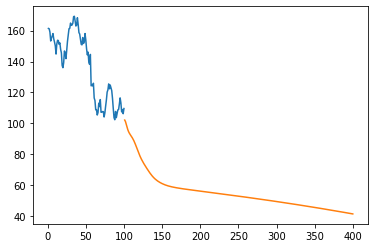

In [28]:
plt.plot(day_new,scaler.inverse_transform(df1[(len(df1)-100):]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

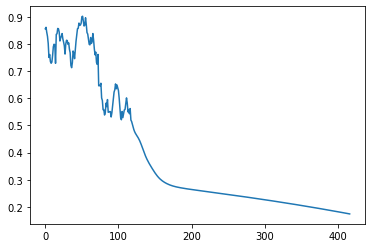

In [29]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[2400:])

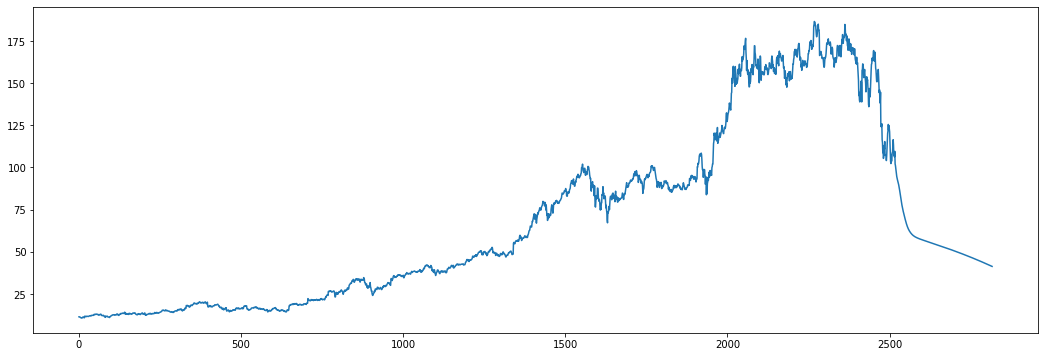

In [30]:
df3=scaler.inverse_transform(df3).tolist()
plt.figure(figsize=(18,6))
plt.plot(df3)